In [1]:
import pandas as pd
import numpy as np 
import torch 
import torch.nn as nn 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [2]:
# read dataset
df= pd.read_csv("data/diabetes.csv", skiprows=1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.shape, print(df.isna().sum()), df['Outcome'].value_counts()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


((768, 9),
 None,
 Outcome
 0    500
 1    268
 Name: count, dtype: int64)

In [4]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [5]:
X = df.iloc[:, :-1]
y= df['Outcome']

x_train, x_test, y_train, y_test= train_test_split(X,y, 
                                                   test_size=0.2, 
                                                   random_state=42,
                                                   stratify=y)

print(f"X_train Shape {x_train.shape}")
print(f"x_test Shape {x_test.shape}")
print(f"y_train Shape {y_train.shape}")
print(f"y_test Shape {y_test.shape}")

X_train Shape (614, 8)
x_test Shape (154, 8)
y_train Shape (614,)
y_test Shape (154,)


In [6]:
# Equal proportion of classes amongs the train and test data
y_train.value_counts()/y_train.value_counts().sum() , y_test.value_counts()/y_test.value_counts().sum()

(Outcome
 0    0.651466
 1    0.348534
 Name: count, dtype: float64,
 Outcome
 0    0.649351
 1    0.350649
 Name: count, dtype: float64)

In [7]:
len(x_train)

614

In [53]:
class Mydataset(Dataset):
    """
        Args:
            data (array-like): Input data.
            labels (array-like): Corresponding labels.
            transform (callable, optional): Optional transform to be applied on a sample.
    """
    def __init__(self, input_feature, output_feature):
        super().__init__()
        self.input_feature= input_feature
        self.output_feature = output_feature

    def __len__(self):
        return len(self.input_feature)
    
    def __getitem__(self, index):
        data= self.input_feature[index]
        label= self.output_feature[index]
        return data, label
    

In [54]:
x_train_tensor= torch.tensor(x_train.values, dtype=torch.float32)
x_test_tensor= torch.tensor(x_test.values, dtype=torch.float32)
y_train_tensor= torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1) #adding Extradimensions
y_test_tensor= torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1) #adding Extradimensions

print(f"X_train tensor Shape {x_train_tensor.shape}")
print(f"x_test tensor Shape {x_test_tensor.shape}")
print(f"y_train tensor Shape {y_train_tensor.shape}")
print(f"y_test tensor Shape {y_test_tensor.shape}")


X_train tensor Shape torch.Size([614, 8])
x_test tensor Shape torch.Size([154, 8])
y_train tensor Shape torch.Size([614, 1])
y_test tensor Shape torch.Size([154, 1])


In [55]:
batch_size= 16

train_dataset = Mydataset(x_train_tensor, y_train_tensor)
test_dataset =  Mydataset(x_test_tensor, y_test_tensor)

train_dataloader= DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
validation_dataloder = DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=False)

In [56]:
iter_ = iter(train_dataloader)
next(iter_)[0].shape

torch.Size([32, 8])

In [57]:

numberofbatches= len(train_dataset) / batch_size
print(f"There will be {round(numberofbatches)} batches.")

There will be 38 batches.


# **Model Building**

In [118]:
# class BinaryClassifier(nn.Module):
#     def __init__(self, input_size):
#         super(BinaryClassifier, self).__init__()
#         self.linear1 = nn.Linear(input_size, 16)
#         self.relu = nn.ReLU()
#         self.linear2 = nn.Linear(16, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.linear1(x)
#         x = self.relu(x)
#         x = self.linear2(x)
#         x = self.sigmoid(x)
#         return x
    

class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=16, dropout_rate=0.4):
        super(BinaryClassifier, self).__init__()

        self.linear1 = nn.Linear(input_size, hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.batch_norm1(x)  
        x = self.relu(x)  
        x = self.dropout(x)  
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x 
    
# model obj
# model= BinaryClassifier(input_size= x_train.shape[1])
model= BinaryClassifier(input_size= x_train.shape[1])

In [119]:
learning_rate= 0.001
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs= 10


In [120]:
train_acc, test_acc= [],[] 
train_loss_hist, test_loss_hist= [],[] 

for epoch in range(epochs):
    train_loss, test_loss = 0.0, 0.0
    train_correct, test_correct = 0,0
    train_total, test_total = 0,0

    model.train()
    
    for steps,data in enumerate(train_dataloader):
        inputs, labels= data
        outputs= model(inputs)
        loss= criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item() * inputs.size(0)

        training_prediction = (outputs > 0.5).float()
        train_correct += (training_prediction == labels).sum().item()

        train_total += inputs.size(0)

    model.eval()
    with torch.no_grad():
        for tst_steps,testdata in enumerate(validation_dataloder):
            test_inputs, test_labels = testdata

            test_pred= model(test_inputs)

            t_loss= criterion(test_pred, test_labels)

            test_loss +=  t_loss.item() * test_inputs.size(0)

            test_predicted = (test_pred > 0.5).float()
            test_correct += (test_predicted == test_labels).sum().item()

            test_total += test_labels.size(0)

    print(f"Epoch:{epoch} | Train loss: {train_loss/train_total:.4f} | Train accuracy: {(train_correct/train_total)*100:.2f}% | Test loss: {test_loss/test_total:.4f} | Test accuracy: {(test_correct/test_total)*100:.2f}%")
    
    # for visialization 

    train_acc.append(train_correct/train_total)
    test_acc.append(test_correct/test_total)
    train_loss_hist.append(train_loss/train_total)
    test_loss_hist.append(test_loss/test_total)


Epoch:0 | Train loss: 0.7412 | Train accuracy: 45.93% | Test loss: 0.7361 | Test accuracy: 37.01%
Epoch:1 | Train loss: 0.7080 | Train accuracy: 52.61% | Test loss: 0.7074 | Test accuracy: 44.16%
Epoch:2 | Train loss: 0.6957 | Train accuracy: 55.05% | Test loss: 0.6834 | Test accuracy: 56.49%
Epoch:3 | Train loss: 0.6644 | Train accuracy: 63.84% | Test loss: 0.6651 | Test accuracy: 64.29%
Epoch:4 | Train loss: 0.6471 | Train accuracy: 68.24% | Test loss: 0.6543 | Test accuracy: 65.58%
Epoch:5 | Train loss: 0.6212 | Train accuracy: 71.82% | Test loss: 0.6352 | Test accuracy: 68.83%
Epoch:6 | Train loss: 0.6210 | Train accuracy: 70.20% | Test loss: 0.6161 | Test accuracy: 72.08%
Epoch:7 | Train loss: 0.6022 | Train accuracy: 70.36% | Test loss: 0.6031 | Test accuracy: 71.43%
Epoch:8 | Train loss: 0.5803 | Train accuracy: 73.78% | Test loss: 0.5939 | Test accuracy: 71.43%
Epoch:9 | Train loss: 0.5669 | Train accuracy: 73.62% | Test loss: 0.5780 | Test accuracy: 72.73%


## Save weights

In [123]:
#Save model (save weights)
# torch.save(model.state_dict(), "models/binary_classifier.pth")

In [133]:
# --- Loading the Model ---
loaded_model = BinaryClassifier(8, 16, 0.4) 
loaded_model.load_state_dict(torch.load("models/binary_classifier.pth"))
loaded_model.eval() # Set the model to evaluation mode

BinaryClassifier(
  (linear1): Linear(in_features=8, out_features=16, bias=True)
  (batch_norm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (linear2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [134]:
from sklearn.metrics import accuracy_score, classification_report

# checking trained model report 
model.eval()

predictions= (model(x_test_tensor) > 0.5).float().squeeze()

report1= classification_report(y_true=y_test_tensor.squeeze(), 
                      y_pred= predictions)

conf_m= confusion_matrix(y_true=y_test_tensor.squeeze(), 
                      y_pred= predictions)

print(report1)
print("--"*20)
print(conf_m)

              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80       100
         1.0       0.64      0.52      0.57        54

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.69       154
weighted avg       0.72      0.73      0.72       154

----------------------------------------
[[84 16]
 [26 28]]


In [135]:
from sklearn.metrics import accuracy_score, classification_report

# checking trained model report 
loaded_model.eval()

predictions= (loaded_model(x_test_tensor) > 0.5).float().squeeze()

report2= classification_report(y_true=y_test_tensor.squeeze(), 
                      y_pred= predictions)

conf_m= confusion_matrix(y_true=y_test_tensor.squeeze(), 
                      y_pred= predictions)

print(report2)
print("--"*20)
print(conf_m)

              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80       100
         1.0       0.64      0.52      0.57        54

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.69       154
weighted avg       0.72      0.73      0.72       154

----------------------------------------
[[84 16]
 [26 28]]


In [ ]:
#save complete model
# torch.save(model, "models/binary_classifier_full.pth")

In [126]:
import seaborn as sns 
import matplotlib.pyplot as plt

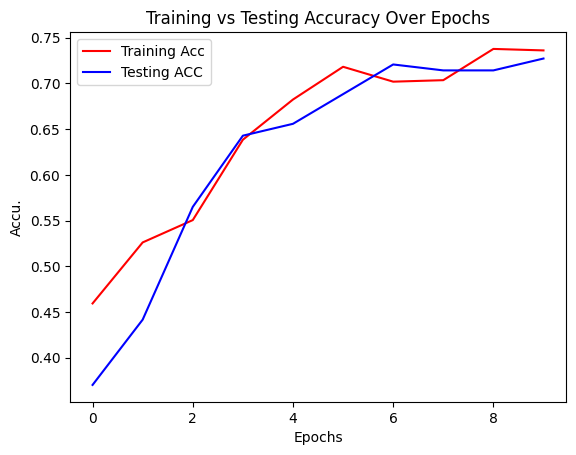

In [127]:
sns.lineplot(x=range(epochs), y=train_acc, color="red", label="Training Acc")
sns.lineplot(x=range(epochs), y=test_acc, color="blue", label="Testing ACC")
plt.title("Training vs Testing Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accu.")
plt.legend()
plt.show()

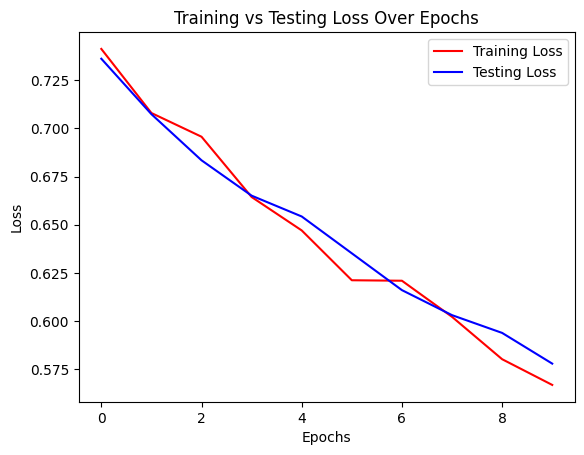

In [128]:
sns.lineplot(x=range(epochs), y=train_loss_hist, color="red", label="Training Loss")
sns.lineplot(x=range(epochs), y=test_loss_hist, color="blue", label="Testing Loss")
plt.title("Training vs Testing Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Validation

In [132]:
# epochs = 50

# for epoch in range(epochs):
#     train_loss = 0.0
#     train_correct = 0
#     train_total = 0
#     test_loss = 0.0
#     test_correct = 0
#     test_total = 0

#     # Training Phase
#     model.train()
#     for inputs, labels in train_dataloader:
#         # Zero the gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs)

#         # Calculate the loss
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         # Update training loss and accuracy
#         train_loss += loss.item() * inputs.size(0)
#         predicted = (outputs > 0.5).float() # Threshold at 0.5 for binary classification
#         train_total += labels.size(0)
#         train_correct += (predicted == labels).sum().item()

#     avg_train_loss = train_loss / train_total
#     train_accuracy = 100 * train_correct / train_total

#     # Evaluation Phase
#     model.eval()
#     with torch.no_grad():
#         for inputs, labels in validation_dataloder:
#             # Forward pass
#             outputs = model(inputs)

#             # Calculate the loss
#             loss = criterion(outputs, labels)

#             # Update test loss and accuracy
#             test_loss += loss.item() * inputs.size(0)
#             predicted = (outputs > 0.5).float()
#             test_total += labels.size(0)
#             test_correct += (predicted == labels).sum().item()

#     avg_test_loss = test_loss / test_total
#     test_accuracy = 100 * test_correct / test_total

#     print(f"Epoch [{epoch+1}/{epochs}], "
#           f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
#           f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# print("Finished Training")